In [1]:
import os
import numpy as np

import yaml
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import seaborn as sns

from OrderParameter import *

# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""
    
# read mapping file
def read_mapping_file(mapping_file, atom1):
    with open(mapping_file, 'rt') as mapping_file:
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
    return m_atom1

def read_mapping_filePAIR(mapping_file, atom1, atom2):
    with open(mapping_file, 'rt') as mapping_file:
            print(mapping_file)
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
#                    print(m_atom1)
                if atom2 in line: 
                    m_atom2 = line.split()[1]
#                    print(m_atom2)
    return m_atom1, m_atom2

def make_positive_angles(x):
    for i in range(len(x)):
        if x[i] < 0:
            x[i] = np.degrees(x[i]) + 360
        else:
            x[i] = np.degrees(x[i])
    return x

## Calculate the the angle between PN vector and z-axis  and plot the distribution of angles for each simulation

In [2]:
#Calculate the angle between PN vector and z-axis for each lipid residues

lipids = {'POPS','POPE','POPG','POPC'}
#lipids = {'POPE'}
atom1 = 'M_G3P2_M'
#atom2 = 'M_G3C5O1_M'   #for POPG
atom2 = 'M_G3N6_M'

colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}

h = []


for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                for molname in lipids:
                    doi = readme.get('DOI')
                    trj = readme.get('TRJ')
                    tpr = readme.get('TPR')
                    trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                    tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                    gro_name = subdir + '/conf.gro'
                    trj_url = download_link(doi, trj[0][0])
                    tpr_url = download_link(doi, tpr[0][0])
    

                    #Download tpr and xtc files to same directory where dictionary and data are located
                    if (not os.path.isfile(tpr_name)):
                        response = urllib.request.urlretrieve(tpr_url, tpr_name)
                        
                    if (not os.path.isfile(trj_name)):
                        response = urllib.request.urlretrieve(trj_url, trj_name)
                        
                    
                
                    if sum(readme['N' + molname]) > 0:
                        print('Analyzing '+molname+' in '+filepath)
                        fig= plt.figure(figsize=(12,9))
                        if (not os.path.isfile(gro_name)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name}  -dump 0 -o {gro_name}
                        
                        xtcwhole=subdir + '/whole.xtc'
                        if (not os.path.isfile(xtcwhole)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name} -o {xtcwhole} -pbc mol 
                        
                        #for key in readme['MAPPING_DICT']:    
                        #    mapping_file = readme['MAPPING_DICT'][key]
                        #    print(mapping_file)
                        
                        #print(readme)
                        #print(readme['MAPPING_DICT'])
                        #print(readme['MAPPING_DICT'][molname])
                        #mapping_file='../../../../../../scripts/mapping_files/'+mapping_file
                        mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                                                
                        try:
                            atoms = read_mapping_filePAIR(mapping_file, atom1 , atom2)
                        except:
                            print(atom1 + " and " + atom2 + " not found in the mapping file.")
                            continue
                        try:
                            anglesMeanError = read_trj_PN_angles(molname, atoms, tpr_name, xtcwhole, gro_name)
                        except OSError:
                            print("Could not calculate angles for " + molname + " from files " + tpr_name + " and " + trj_name)
                            continue
                        angles = anglesMeanError[0]
                        resAverageAngles = anglesMeanError[1]
                        totalAverage = anglesMeanError[2]
                        totalAverageError = anglesMeanError[3]
                        
                        #print(resAverageAngles)
                        
                        #fig= plt.figure(figsize=(12,9))
                       # print(len(angles))
                        #dist = [ 0 for i in range(len(angles))]
                        #distSUM = [ 0 for i in range(100)]
                       # print(distSUM)
                        #for i in range(len(angles)):
                         #   dist[i] = plt.hist(angles[i], bins=100, density=True)
                         #   distSUM = np.add(distSUM,dist[i][0])
                            
                       # print(distSUM)
                        #distSUM = [x / len(angles) for x in distSUM]
                      
                        #print(len(dist))
                        #xaxis = [ 0 for i in range(len(dist[0][1])-1)]
                        #for i in range(len(dist[0][1])-1):
                         #   xaxis[i]=(dist[0][1][i])
                      #  xaxis = [0:1:180]
                            
                        #h.append(plt.plot(xaxis,distSUM,color=colors[molname], label = readme.get('SYSTEM'))[0])
                        plt.hist(resAverageAngles,bins=180,color=colors[molname], label = readme.get('SYSTEM'),density = True)[0]
                        
                       # sns.distplot(xaxis,distSUM, hist=False,color=colors[molname], label = readme.get('SYSTEM'))
                        plt.legend()
                        plt.xlabel("Angle (°)")
                        #print(molname)
                        #print(colors[molname])
                        
                        HGorientationFOLDERS = subdir.replace("Simulations","HGorientation")
                        !mkdir -p {HGorientationFOLDERS}
                        !cp {READMEfilepath} {HGorientationFOLDERS}
                        outfile=open(str(HGorientationFOLDERS) + '/PNvectorDIST.dat','w')
                        for i in range(len(xaxis)):
                            #print(xaxis[i],distSUM[i])
                            outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
                        outfile.close()
            
#labels = [l.get_label() for l in h]
#plt.legend(h, labels, loc='best',ncol=2)
#plt.xlabel("Angle (°)")

Analyzing POPG in ../Data/Simulations/0d5/d1d/0d5d1dcb43e775faf4e53c4f9ff255a67481bd38/9b487701b24d3fad83991e311188b08d3d5ea768/README.yaml
<_io.TextIOWrapper name='./mapping_files/mappingPOPGcharmm.txt' mode='rt' encoding='UTF-8'>
M_G3P2_M and M_G3N6_M not found in the mapping file.
Analyzing POPS in ../Data/Simulations/1b2/6e6/1b26e6c750b4f39c37770422cd4d3c40240cf111/995bc873b811ca09c916b47784fa33bb9d793732/README.yaml
<_io.TextIOWrapper name='./mapping_files/mappingPOPScharmm.txt' mode='rt' encoding='UTF-8'>
Analyzing POPE in ../Data/Simulations/2d4/61b/2d461bc9d828af155146162ef42438974e4cbeaf/c8ce4cc36ef6ec7a085cf011176a92d9d746a792/README.yaml
<_io.TextIOWrapper name='./mapping_files/mappingPOPEcharmm.txt' mode='rt' encoding='UTF-8'>
Analyzing POPC in ../Data/Simulations/b4f/866/b4f866c0dabffa6cd891e91841591d46590f34aa/a231c358dd8c0b7bb4cf558ccdbf022373354a9a/README.yaml
<_io.TextIOWrapper name='./mapping_files/mappingPOPCcharmm.txt' mode='rt' encoding='UTF-8'>
Cosine is too large

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 1 Axes>

<Figure size 864x648 with 1 Axes>

<Figure size 864x648 with 1 Axes>

<Figure size 864x648 with 1 Axes>

In [15]:
## Plot order parameter for selected DOIs

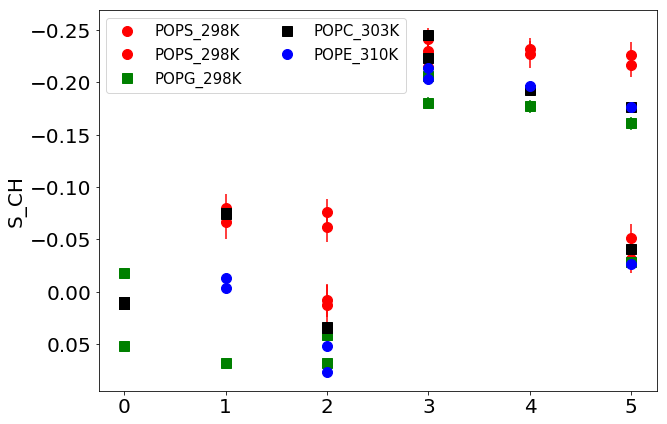

In [32]:
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
markers = {'POPC' :'s','POPS':'o','POPE':'o','POPG':'s'}
lipids = {'POPC','POPS','POPE','POPG'}
DOIs = {'POPC' :'10.5281/zenodo.3474862','POPG' :'10.5281/zenodo.1011096','POPS' :'10.5281/zenodo.1129415','POPE' :'10.5281/zenodo.2641987'}


fig= plt.figure(figsize=(10,7))
for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
               # print(readme)
            for lipid in lipids:
                if DOIs[lipid] in readme.get('DOI'):
                    OPfilepath = subdir + '/OrderParameters.json'
                    #print(OPfilepath)
                    #print(readme.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data = json.load(json_file)
                    for key,value in data.items():
                       #print (key,value[0][0],value[0][2])
                        plt.gca().invert_yaxis()
                        
                        
                        if lipid == 'POPG' and 'M_G3C6_M' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3N6' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C5_M' in key:
                            plt.plot(1,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(1,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C4_M' in key:
                            plt.plot(2,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(2,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3_M' in key:
                            plt.plot(3,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(3,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G2_M' in key:
                            plt.plot(4,value[0][0],"s",color=colors[lipid],label=readme.get('SYSTEM'), marker=markers[lipid], markersize=10)
                            plt.errorbar(4,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G1_M' in key:
                            plt.plot(5,value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
                            plt.errorbar(5,value[0][0],yerr=value[0][2],color=colors[lipid])
            
plt.legend(loc='best',ncol=2, fontsize=15)
plt.ylabel('S_CH', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('../Figs/CHARMMfromLIPIDS.eps', bbox_inches='tight')
                    

## Plot order parameters for each simulation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


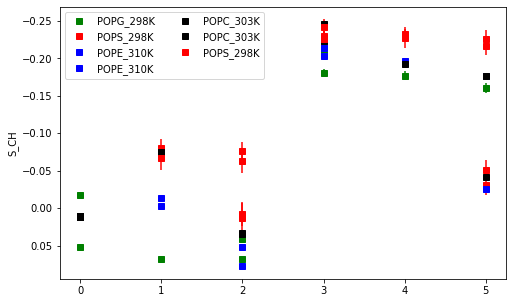

In [22]:
mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                                                
                        try:
                            atoms = read_mapping_filePAIR(mapping_file, atom1 , atom2)
                        except:
                            print(atom1 + " and " + atom2 + " not found in the mapping file.")
                            continue

colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
lipids = {'POPC','POPS','POPE','POPG'}


fig= plt.figure(figsize=(8,5))
for subdir, dirs, files in os.walk(r'/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
               # print(readme)
            for lipid in lipids:
                if lipid in readme.get('SYSTEM') and sum(readme['N' + lipid]) > 0:
                    OPfilepath = subdir + '/OrderParameters.json'
                    #print(OPfilepath)
                    #print(readme.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data = json.load(json_file)
                    for key,value in data.items():
                       #print (key,value[0][0],value[0][2])
                        plt.gca().invert_yaxis()
                        plt.ylabel('S_CH')
                        
                        if lipid == 'POPG' and 'M_G3C6_M' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3N6' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C5_M' in key:
                            plt.plot(1,value[0][0],"s",color=colors[lipid],label=readme.get('SYSTEM'))
                            plt.errorbar(1,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C4_M' in key:
                            plt.plot(2,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(2,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3_M' in key:
                            plt.plot(3,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(3,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G2_M' in key:
                            plt.plot(4,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(4,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G1_M' in key:
                            plt.plot(5,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(5,value[0][0],yerr=value[0][2],color=colors[lipid])
            
plt.legend(loc='best',ncol=2)
plt.savefig('/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Figs/CHARMMfromLIPIDS.eps')
                    

## Calculate and plot dihedral angles for each simulation

In [ ]:
def calcDihedrals(trj, tpr)


M_G3P2_M
Analyzing POPS in ../Data/Simulations/1b2/6e6/1b26e6c750b4f39c37770422cd4d3c40240cf111/995bc873b811ca09c916b47784fa33bb9d793732/README.yaml
P O12 C11 C12
Analyzing POPS in ../Data/Simulations/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a5a7377c8a46341eba603f320cf7/README.yaml
P O12 C11 C12
Analyzing POPC in ../Data/Simulations/b4f/866/b4f866c0dabffa6cd891e91841591d46590f34aa/a231c358dd8c0b7bb4cf558ccdbf022373354a9a/README.yaml
                      :-) GROMACS - gmx trjconv, 2020 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Cars

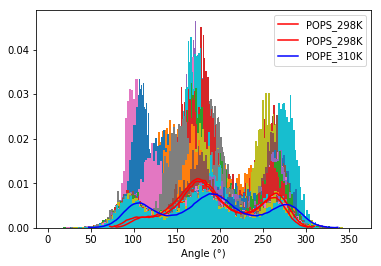

In [6]:
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
#lipids = {'POPC','POPS','POPE','POPG'}
#lipids = {'POPE','POPG','POPS','POPC'}
lipids = {'POPS','POPE','POPC'}
DIHatoms = ['M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M']
#DIHatoms = ['M_G3C5_M', 'M_G3C4_M', 'M_G3O3_M','M_G3P2_M' ]
print(DIHatoms[0])

                                              
for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                for molname in lipids:
                    doi = readme.get('DOI')
                    trj = readme.get('TRJ')
                    tpr = readme.get('TPR')
                    trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                    tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                    gro_name = subdir + '/conf.gro'
                    trj_url = download_link(doi, trj[0][0])
                    tpr_url = download_link(doi, tpr[0][0])
    
                    #Download tpr and xtc files to same directory where dictionary and data are located
                    if (not os.path.isfile(tpr_name)):
                        response = urllib.request.urlretrieve(tpr_url, tpr_name)
                        
                    if (not os.path.isfile(trj_name)):
                        response = urllib.request.urlretrieve(trj_url, trj_name)
                
                    if sum(readme['N' + molname]) > 0:
                        print('Analyzing '+molname+' in '+filepath)
                        #fig= plt.figure(figsize=(12,9))
                        if (not os.path.isfile(gro_name)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name}  -dump 0 -o {gro_name}
                        
                        xtcwhole=subdir + '/whole.xtc'
                        if (not os.path.isfile(xtcwhole)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name} -o {xtcwhole} -pbc mol 
                        
                        try:
                            traj = mdtraj.load(xtcwhole, top = gro_name)
                            #print(lipid)
                        except FileNotFoundError or OSError:
                            continue
                       
                        mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                        try:
                            atom1 = read_mapping_file(mapping_file, DIHatoms[0])
                            atom2 = read_mapping_file(mapping_file, DIHatoms[1])
                            atom3 = read_mapping_file(mapping_file, DIHatoms[2])
                            atom4 = read_mapping_file(mapping_file, DIHatoms[3])
                            print(atom1,atom2,atom3,atom4)
                        except:
                            #print(atom1 + " and " + atom2 + " not found in the mapping file.")
                            print("Some atom not found in the mapping file.")
                            continue
                        index = [ [] for i in range(traj.topology.n_residues)]
                        dihRESULT = []
                        for residue in traj.topology.residues:
                            atom1ind=traj.topology.select("name == " + atom1 + " and resid == " + str(residue.index))
                            atom2ind=traj.topology.select("name == " + atom2 + " and resid == " + str(residue.index))
                            atom3ind=traj.topology.select("name == " + atom3 + " and resid == " + str(residue.index))
                            atom4ind=traj.topology.select("name == " + atom4 + " and resid == " + str(residue.index))
                            if(len(atom1ind) > 0):
                                index[residue.index].append(atom1ind[0])
                                index[residue.index].append(atom2ind[0])
                                index[residue.index].append(atom3ind[0])
                                index[residue.index].append(atom4ind[0])
                                dihRESULT.append(mdtraj.compute_dihedrals(traj,[index[residue.index]]))
                                
                        dihRESULT = [make_positive_angles(x) for x in dihRESULT ]
                        dist = [ 0 for i in range(len(dihRESULT))]
                        distSUM = [ 0 for i in range(100)]
                        for i in range(len(dihRESULT)):
                            dist[i] =  plt.hist(dihRESULT[i], bins=100,density=True);
                            distSUM = np.add(distSUM,dist[i][0])
                            
                        
                        distSUM = [x / len(dihRESULT) for x in distSUM]
                        xaxis = [ 0 for i in range(len(dist[0][1])-1)]
                        for i in range(len(dist[0][1])-1):
                            xaxis[i]=(dist[0][1][i])
                            
                        plt.plot(xaxis,distSUM,color=colors[molname], label = readme.get('SYSTEM'))[0] 
                        plt.legend()
                        plt.xlabel("Angle (°)")
                        
                        dihedralFOLDERS = subdir.replace("Simulations","dihedral")
                        !mkdir -p {dihedralFOLDERS}
                        !cp {READMEfilepath} {dihedralFOLDERS}
                        outfile=open(str(dihedralFOLDERS) + '/' + DIHatoms[0] + DIHatoms[1] + DIHatoms[2] + DIHatoms[3] +'.dat','w')
                        for i in range(len(xaxis)):
                            outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
                        outfile.close()
                        

In [ ]:
dihRESULTall = []
#dihRESULTsum=np.add(dihRESULT[5],dihRESULT[5]*-1)
#sum=0ihRESULTsum=np.add(dihRESULTsum,dihRESULT[i])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[9])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[10])
for i in range(traj.topology.n_residues):
    if(len(dihRESULT[i]) > 0):
        dihRESULTall=dihRESULT[0] + dihRESULT[i]
print(dihRESULTall)



In [5]:
dihedralFOLDERS = subdir.replace("Simulations","dihedral")
!mkdir -p {dihedralFOLDERS}
!cp {READMEfilepath} {dihedralFOLDERS}
outfile=open(str(dihedralFOLDERS) + '/' + DIHatoms[0] + DIHatoms[1] + DIHatoms[2] + DIHatoms[3] +'.dat','w')
for i in range(len(xaxis)):
    outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
outfile.close()
                        

In [3]:
print(DIHatoms)
print(dihRESULT[1])
#for x in dihRESULT:
#    print(len(x))
dihRESULT = [make_positive_angles(x) for x in dihRESULT ]
print(dihRESULT[1])
#pandas.df[dihRESULT]


['M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M']
[[190.79431]
 [216.92178]
 [192.65016]
 ...
 [288.60284]
 [281.95065]
 [170.17767]]
[[10931.708]
 [12428.702]
 [11038.041]
 ...
 [16535.725]
 [16154.582]
 [ 9750.462]]


In [ ]:
dist = [ 0 for i in range(len(dihRESULT))]
distSUM = [ 0 for i in range(50)]
for i in range(len(dihRESULT)):
    dist[i] =  plt.hist(dihRESULT[i], bins=50)
    distSUM = np.add(distSUM,dist[i][0])
    #print(dist[i][0])
    #print(distSUM)

In [ ]:
#totDIST=[distSUM,dist[0][1]]
#print(totDIST)
#print(dihRESULT[0])
#print(dist[0])
print(distSUM)
xaxis = [ 0 for i in range(len(dist[0][1])-1)]
for i in range(len(dist[0][1])-1):
    xaxis[i]=(dist[0][1][i])
    print(xaxis)
plt.plot(xaxis,distSUM)

In [ ]:
dihs = top.select("name == P or name == C11 or name == C12 or name == N")
index = [ [] for i in range(traj.topology.n_residues)]
dihRESULT = [ [] for i in range(traj.topology.n_residues)]
for residue in traj.topology.residues:
    for i in dihs:
        if(traj.topology.atom(i).residue == residue): 
            index[residue.index].append(traj.topology.atom(i).index)
    dihRESULT[residue.index] = mdtraj.compute_dihedrals(traj,[index[residue.index]])
    print(dihRESULT[residue.index])

In [ ]:
mdtraj.compute_dihedrals(traj,[dihs])

In [ ]:
top

In [8]:
mapping_file = "./mapping_files/mappingPOPEcharmm.txt"
dihedrals = parseDihedralInput(mapping_file)


['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2O1_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G1_M']
['M_G2C19_M', 'M_G2C18_M', 'M_G2C17_M', 'M_G2C16_M', 'M_G2C15_M', 'M_G2C14_M', 'M_G2C13_M', 'M_G2C12_M', 'M_G2C11_M', 'M_G2C10_M', 'M_G2C9_M', 'M_G2C8_M', 'M_G2C7_M', 'M_G2C6_M', 'M_G2C5_M', 'M_G2C4_M', 'M_G2C3_M', 'M_G2C2O1_M', 'M_G2C2_M', 'M_G2O1_M', 'M_G2_M']
['M_G3_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O1_M', 'M_G3P2O2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M', 'M_G3N6_M']
['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M']
['M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M']
['M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M']
['M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M']
['M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M']
['M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M']
['M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M']
['M_G1C10_M', 'M_G1C9

In [9]:
print(dihedrals)

[]
